In [147]:
import os
import sys
from pathlib import Path

SRC_PATH = Path(__name__).resolve().parents[1]

sys.path.append(str(SRC_PATH))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from data_generator.pmu import VirtualPMU
from sklearn.metrics import confusion_matrix

In [211]:
pmu = VirtualPMU(sample_rate=60, event_rate=0.5, error_rate=0.03)

In [212]:
df = pmu.create_dataframe(duration=200)

In [213]:
df["label_name"].unique()

array(['Normal', 'voltage_voltage oscilation', 'frequency_low oscilation',
       'phase_angle_shift', 'voltage_sag'], dtype=object)

In [151]:
df.reset_index(drop=True, inplace=True)

In [152]:
df.describe()

,timestamp,frequency,voltage,current,phase_angle,label
count,120,118.000000,116.000000,119.000000,117.000000,120.0
mean,2024-10-04 17:14:02.430016768,60.000092,1.000090,0.949787,-0.000253,0.0
min,2024-10-04 17:13:02.930017,59.997228,0.996045,0.946237,-0.004273,0.0
25%,2024-10-04 17:13:32.680016896,59.999333,0.999168,0.948757,-0.001343,0.0
50%,2024-10-04 17:14:02.430017024,59.999967,1.000089,0.949973,-0.000279,0.0
75%,2024-10-04 17:14:32.180017152,60.000810,1.001138,0.950800,0.000788,0.0
max,2024-10-04 17:15:01.930017,60.003157,1.003482,0.952893,0.003082,0.0
std,NaN,0.001134,0.001502,0.001496,0.001530,0.0


In [153]:
print("\nMissing Values Count by Column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Count by Column:
frequency      2
voltage        4
current        1
phase_angle    3
dtype: int64



Visualizing Missing Values...


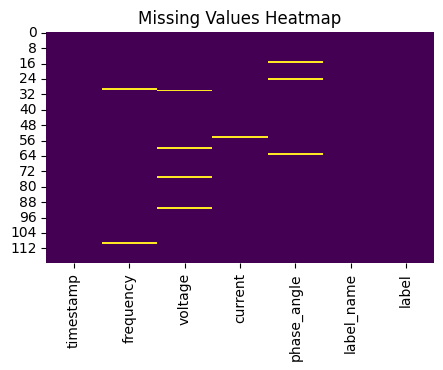

In [154]:
print("\nVisualizing Missing Values...")
plt.figure(figsize=(5, 3))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

### Analysis

- No Categorical Features have been included.
- frequency, voltage, current, phase_angle
    - Mean - 59.999843, 0.999991,	0.949996, 0.013378,
    - Std - 0.021878, 0.014863, 0.009005, 0.707026
- Frequency, Voltage, Current have small standard deviations but phase angle is quite spread.

- Typically, there are 1000 over missing value, but we can handle simple impuation forward fill and backfill because generally the features have small spread.

In [155]:
class MissingHandler(object):
    def handle_missing_values(self, data_frame):
        """Fill missing values."""
        return data_frame.ffill().bfill()

In [156]:
missing_handler = MissingHandler()

pmu_data = missing_handler.handle_missing_values(df)

In [157]:
print("\nMissing Values Count by Column:")
missing_values = pmu_data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Count by Column:
Series([], dtype: int64)


In [158]:
pmu_data["label"].value_counts()

label
0    120
Name: count, dtype: int64

In [159]:
pmu_data["label_name"].value_counts()

label_name
Normal    120
Name: count, dtype: int64

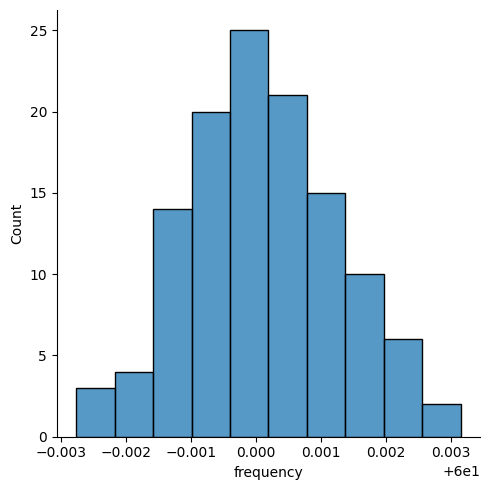

In [160]:

sns.displot(pmu_data["frequency"])

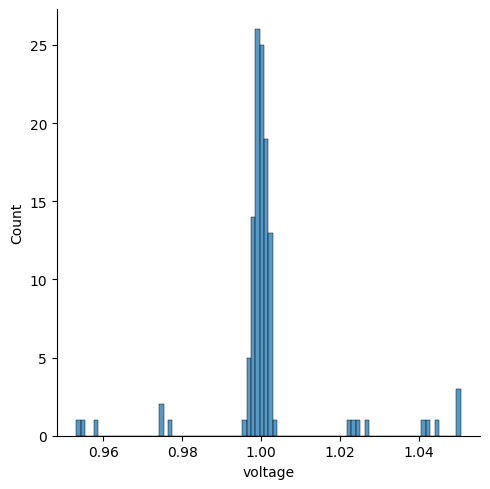

In [95]:

sns.displot(pmu_data["voltage"])

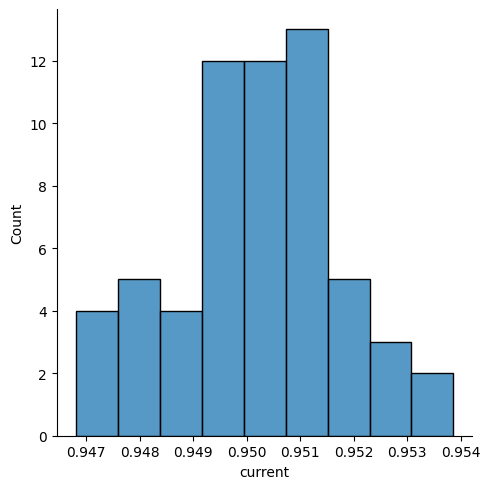

In [69]:
sns.displot(pmu_data["current"])

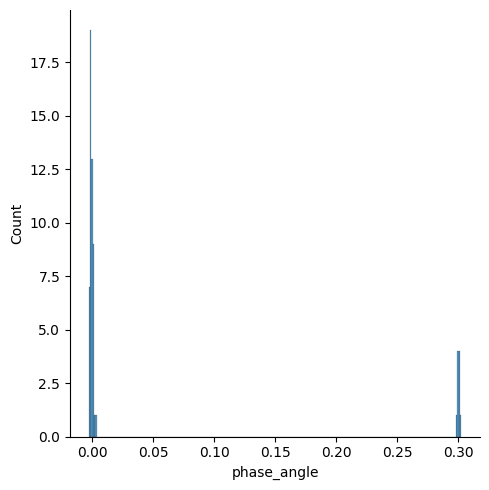

In [70]:
sns.displot(pmu_data["phase_angle"])

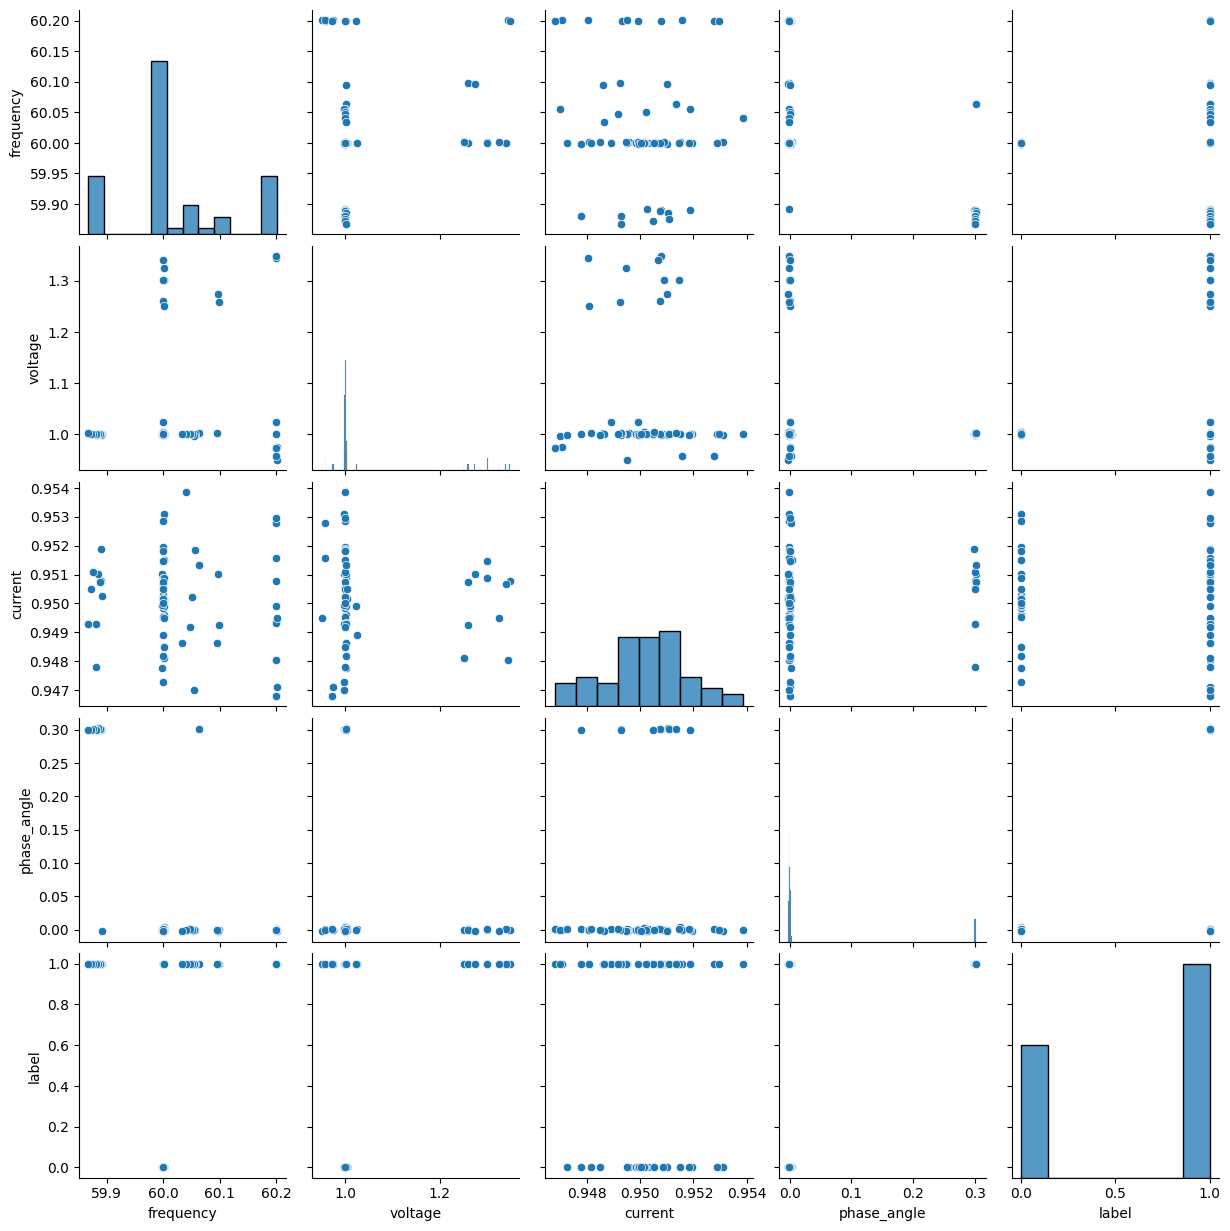

In [71]:
sns.pairplot(pmu_data.drop(labels=["timestamp", "label_name"], axis=1))

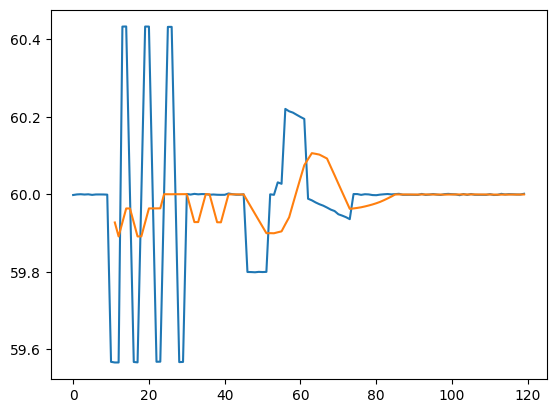

In [72]:

plt.plot(pmu_data["frequency"][:2000])
plt.plot(pmu_data["frequency"].rolling(12).mean().dropna()[:2000])

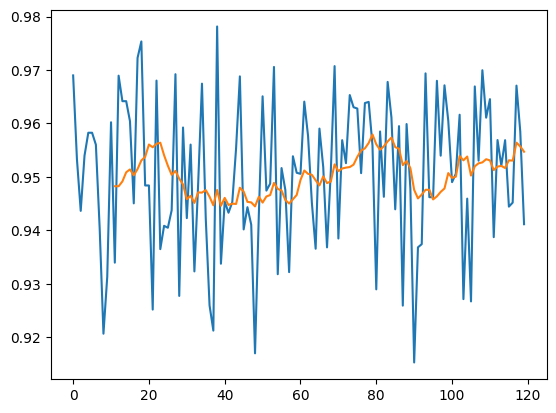

In [73]:

plt.plot(pmu_data["current"][:2000])
plt.plot(pmu_data["current"].rolling(12).mean().dropna()[:2000])

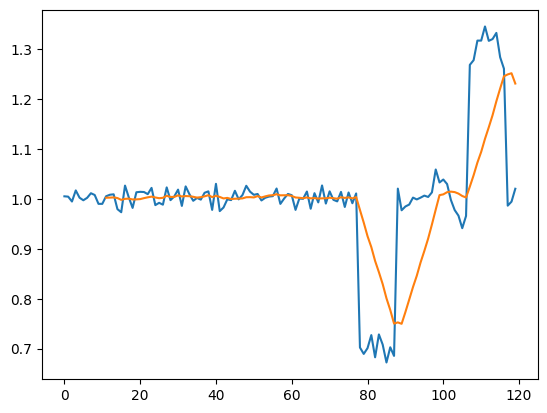

In [74]:

plt.plot(pmu_data["voltage"][:2000])
plt.plot(pmu_data["voltage"].rolling(12).mean().dropna()[:2000])

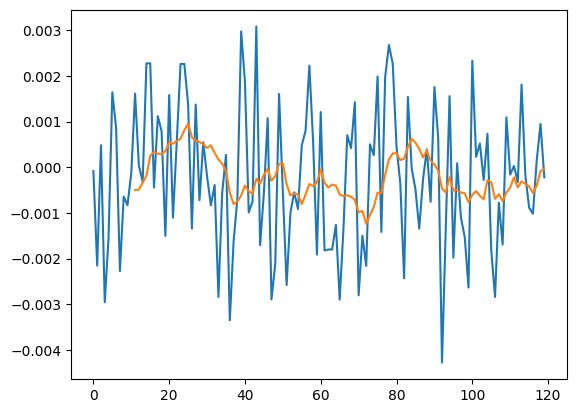

In [161]:

plt.plot(pmu_data["phase_angle"][:2000])
plt.plot(pmu_data["phase_angle"].rolling(12).mean().dropna()[:2000])

In [162]:
from src.detectors import FrequencyDetector, TKEODetector, ZscoreDetector, ROCOFDetector

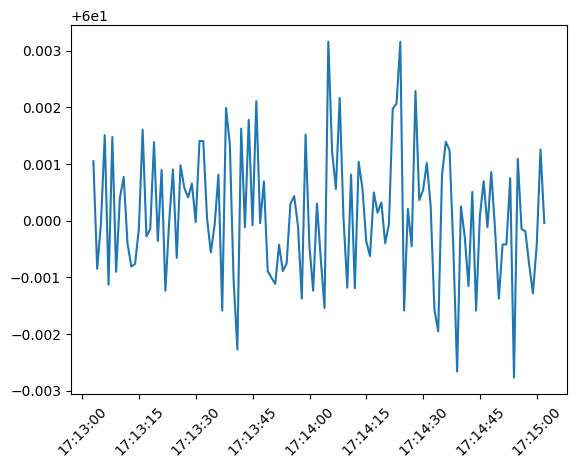

In [163]:
fr_detector = FrequencyDetector()

fr_anomailes = fr_detector.detect(pmu_data["frequency"].values, threshold=0.2)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax.scatter(pmu_data["timestamp"][fr_anomailes], pmu_data["frequency"][fr_anomailes].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

In [164]:
pmu_data["pred"] = np.zeros((pmu_data.shape[0],), dtype=np.int32)

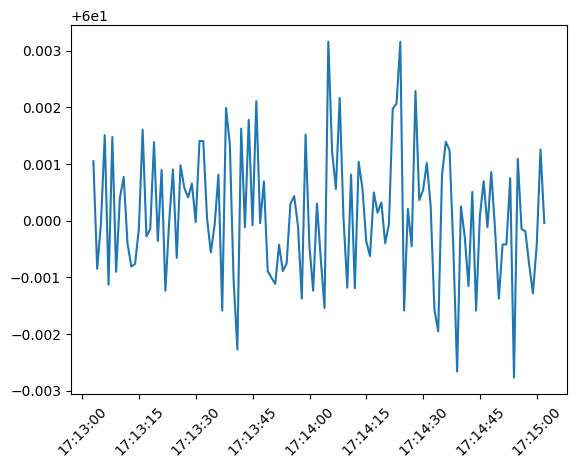

In [165]:
rocof_detector = ROCOFDetector()

rocof_anomailes = rocof_detector.detect(pmu_data["frequency"].values)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax.scatter(pmu_data["timestamp"][rocof_anomailes], pmu_data["frequency"][rocof_anomailes].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

In [166]:
true_frequencies = pmu_data[pmu_data["label_name"].str.startswith("frequency")]


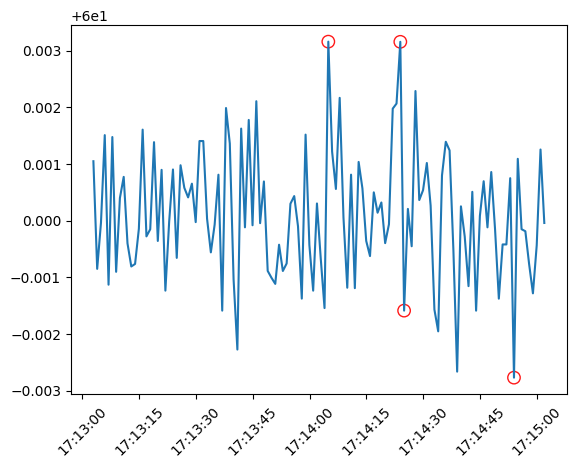

In [172]:
tkeo_detector = TKEODetector()

tkeo_fr_anomailes = tkeo_detector.detect(pmu_data["frequency"].values, threshold=99)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax.scatter(pmu_data["timestamp"][tkeo_fr_anomailes], pmu_data["frequency"][tkeo_fr_anomailes].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

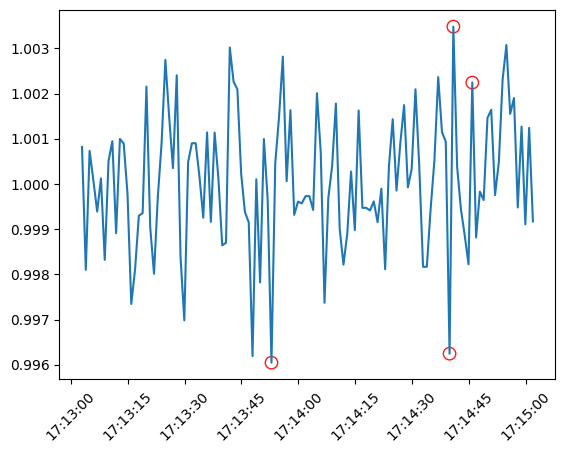

In [173]:
tkeo_detector = TKEODetector()

tkeo_fr_voltage = tkeo_detector.detect(pmu_data["voltage"].values, threshold=99)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["voltage"].values)
ax.scatter(pmu_data["timestamp"][tkeo_fr_voltage], pmu_data["voltage"][tkeo_fr_voltage].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

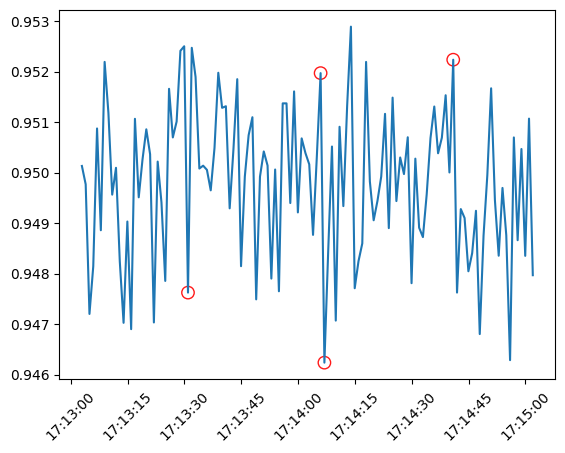

In [174]:
tkeo_detector = TKEODetector()

tkeo_fr_current = tkeo_detector.detect(pmu_data["current"].values, threshold=99)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["current"].values)
ax.scatter(pmu_data["timestamp"][tkeo_fr_current], pmu_data["current"][tkeo_fr_current].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

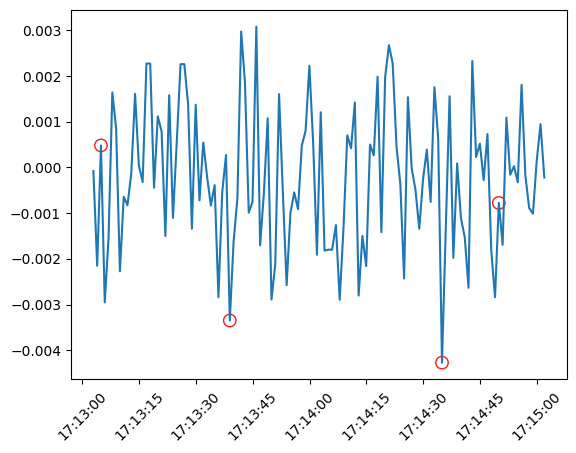

In [175]:
tkeo_detector = TKEODetector()

tkeo_fr_phase = tkeo_detector.detect(pmu_data["phase_angle"].values, threshold=99)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["phase_angle"].values)
ax.scatter(pmu_data["timestamp"][tkeo_fr_phase], pmu_data["phase_angle"][tkeo_fr_phase].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

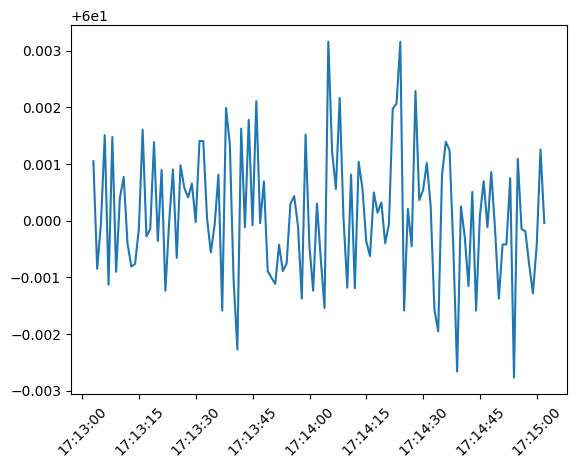

In [176]:
zscore_detector = ZscoreDetector()

zscore_anomalies = zscore_detector.detect(data_frame=pmu_data, feature_list=["frequency"], threshold=3)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax.scatter(pmu_data["timestamp"][zscore_anomalies], pmu_data["frequency"][zscore_anomalies].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

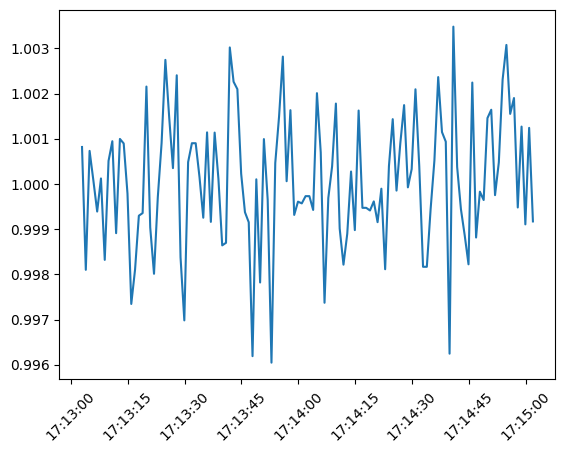

In [177]:
zscore_detector = ZscoreDetector()

zscore_anomalies = zscore_detector.detect(data_frame=pmu_data, feature_list=["voltage"], threshold=3)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["voltage"].values)
ax.scatter(pmu_data["timestamp"][zscore_anomalies], pmu_data["voltage"][zscore_anomalies].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

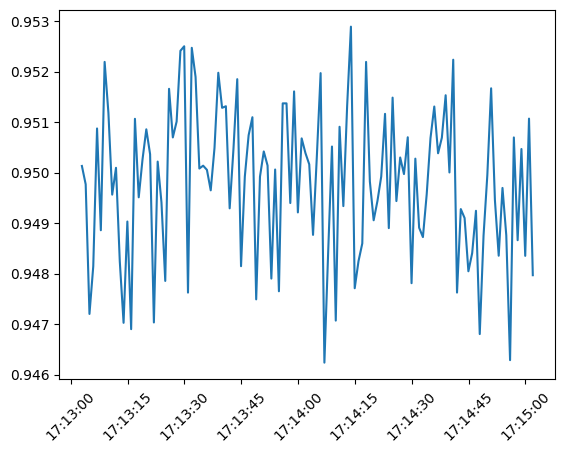

In [178]:
zscore_detector = ZscoreDetector()

zscore_anomalies = zscore_detector.detect(data_frame=pmu_data, feature_list=["current"], threshold=3)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["current"].values)
ax.scatter(pmu_data["timestamp"][zscore_anomalies], pmu_data["current"][zscore_anomalies].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

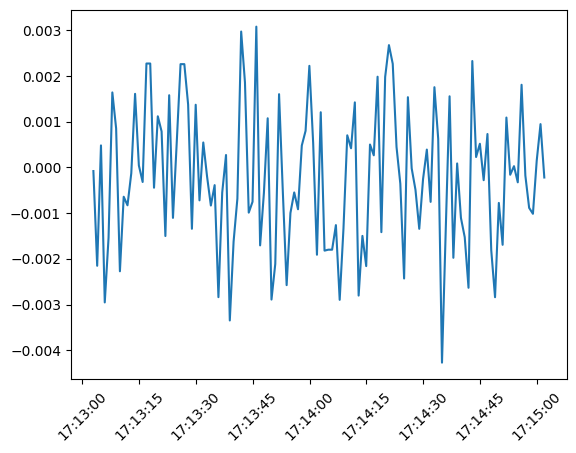

In [179]:
zscore_detector = ZscoreDetector()

zscore_anomalies = zscore_detector.detect(data_frame=pmu_data, feature_list=["phase_angle"], threshold=3)

fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["phase_angle"].values)
ax.scatter(pmu_data["timestamp"][zscore_anomalies], pmu_data["phase_angle"][zscore_anomalies].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);